<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[-0.08094017,  0.66517469, -0.17646927,  1.80861293, -1.31357306,
        -0.90912627],
       [-0.51068161,  0.79358176,  0.08438955,  1.03632563,  0.05198554,
         0.89716524],
       [ 0.00332909,  1.04010985, -0.63958911, -0.89694628,  0.97005485,
        -0.18952223],
       [ 1.38598212,  0.91453181,  1.99145904, -1.14051956, -0.16366794,
        -0.36411512],
       [-1.43130674,  0.0591405 ,  0.07358444,  1.76947683, -0.15293551,
         0.40443346],
       [-1.17725288, -0.76083555, -0.02150642, -1.60927271,  1.22118236,
        -0.09631082],
       [-2.03310706, -0.52603254,  0.79520839,  0.55550385, -0.15228072,
         1.21368922],
       [ 1.58607747,  0.09604259,  0.87277713, -0.98360381,  0.08028253,
         1.98783471]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.282237,0.285214,0.372482,0.067447,0.067631,0.368006
std,1.289228,0.676963,0.819693,1.384136,0.774937,0.949726
min,-2.033107,-0.760836,-0.639589,-1.609273,-1.313573,-0.909126
25%,-1.240766,-0.087153,-0.060247,-1.022833,-0.155619,-0.233170
50%,-0.295811,0.380609,0.078987,-0.170721,-0.050148,0.154061
75%,0.348992,0.823819,0.814601,1.219613,0.302726,0.976296
max,1.586077,1.040110,1.991459,1.808613,1.221182,1.987835


In [16]:
df

,A,B,C,D,E,F
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,-0.080940,-0.510682,0.003329,1.385982,-1.431307,-1.177253,-2.033107,1.586077
B,0.665175,0.793582,1.040110,0.914532,0.059141,-0.760836,-0.526033,0.096043
C,-0.176469,0.084390,-0.639589,1.991459,0.073584,-0.021506,0.795208,0.872777
D,1.808613,1.036326,-0.896946,-1.140520,1.769477,-1.609273,0.555504,-0.983604
E,-1.313573,0.051986,0.970055,-0.163668,-0.152936,1.221182,-0.152281,0.080283
F,-0.909126,0.897165,-0.189522,-0.364115,0.404433,-0.096311,1.213689,1.987835


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,-0.909126,-1.313573,1.808613,-0.176469,0.665175,-0.080940
2023-01-02,0.897165,0.051986,1.036326,0.084390,0.793582,-0.510682
2023-01-03,-0.189522,0.970055,-0.896946,-0.639589,1.040110,0.003329
2023-01-04,-0.364115,-0.163668,-1.140520,1.991459,0.914532,1.385982
2023-01-05,0.404433,-0.152936,1.769477,0.073584,0.059141,-1.431307
2023-01-06,-0.096311,1.221182,-1.609273,-0.021506,-0.760836,-1.177253
2023-01-07,1.213689,-0.152281,0.555504,0.795208,-0.526033,-2.033107
2023-01-08,1.987835,0.080283,-0.983604,0.872777,0.096043,1.586077


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522


In [20]:
df

,A,B,C,D,E,F
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01   -0.080940
2023-01-02   -0.510682
2023-01-03    0.003329
2023-01-04    1.385982
2023-01-05   -1.431307
2023-01-06   -1.177253
2023-01-07   -2.033107
2023-01-08    1.586077
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115


In [24]:
df

,A,B,C,D,E,F
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835


##Selection by label

In [25]:
df.loc[dates[1]]

A   -0.510682
B    0.793582
C    0.084390
D    1.036326
E    0.051986
F    0.897165
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,-0.080940,1.808613
2023-01-02,-0.510682,1.036326
2023-01-03,0.003329,-0.896946
2023-01-04,1.385982,-1.140520
2023-01-05,-1.431307,1.769477
2023-01-06,-1.177253,-1.609273
2023-01-07,-2.033107,0.555504
2023-01-08,1.586077,-0.983604


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,1.385982,-1.140520
2023-01-05,-1.431307,1.769477
2023-01-06,-1.177253,-1.609273


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A    1.385982
D   -1.140520
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

1.036325633392875

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

1.036325633392875

##Selection by position

In [31]:
df.iloc[3]

A    1.385982
B    0.914532
C    1.991459
D   -1.140520
E   -0.163668
F   -0.364115
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,1.385982,0.914532
2023-01-05,-1.431307,0.059141


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-0.510682,0.084390
2023-01-03,0.003329,-0.639589
2023-01-05,-1.431307,0.073584


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,0.665175,-0.176469
2023-01-02,0.793582,0.084390
2023-01-03,1.040110,-0.639589
2023-01-04,0.914532,1.991459
2023-01-05,0.059141,0.073584
2023-01-06,-0.760836,-0.021506
2023-01-07,-0.526033,0.795208
2023-01-08,0.096043,0.872777


In [36]:
# For getting values explicitly
df.iloc[1, 1]

0.7935817562081633

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

0.7935817562081633

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,NaN,0.665175,NaN,1.808613,NaN,NaN
2023-01-02,NaN,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,NaN,NaN,0.970055,NaN
2023-01-04,1.385982,0.914532,1.991459,NaN,NaN,NaN
2023-01-05,NaN,0.059141,0.073584,1.769477,NaN,0.404433
2023-01-06,NaN,NaN,NaN,NaN,1.221182,NaN
2023-01-07,NaN,NaN,0.795208,0.555504,NaN,1.213689
2023-01-08,1.586077,0.096043,0.872777,NaN,0.080283,1.987835


In [40]:
df

,A,B,C,D,E,F
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,-0.080940,0.665175,-0.176469,1.808613,-1.313573,-0.909126,one
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165,one
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522,two
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115,three
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433,four
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311,three
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689,five
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522,two
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433,four
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.176469,1.808613,-1.313573,-0.909126,NaN
2023-01-02,-0.510682,0.793582,0.084390,1.036326,0.051986,0.897165,1.0
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,0.970055,-0.189522,2.0
2023-01-04,1.385982,0.914532,1.991459,-1.140520,-0.163668,-0.364115,3.0
2023-01-05,-1.431307,0.059141,0.073584,1.769477,-0.152936,0.404433,4.0
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,1.221182,-0.096311,5.0
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,-0.152281,1.213689,6.0
2023-01-08,1.586077,0.096043,0.872777,-0.983604,0.080283,1.987835,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.176469,1.808613,5,-0.909126,NaN
2023-01-02,-0.510682,0.793582,0.084390,1.036326,5,0.897165,1.0
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,5,-0.189522,2.0
2023-01-04,1.385982,0.914532,1.991459,-1.140520,5,-0.364115,3.0
2023-01-05,-1.431307,0.059141,0.073584,1.769477,5,0.404433,4.0
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,5,-0.096311,5.0
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,5,1.213689,6.0
2023-01-08,1.586077,0.096043,0.872777,-0.983604,5,1.987835,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.176469,-1.808613,-5,-0.909126,NaN
2023-01-02,-0.510682,-0.793582,-0.084390,-1.036326,-5,-0.897165,-1.0
2023-01-03,-0.003329,-1.040110,-0.639589,-0.896946,-5,-0.189522,-2.0
2023-01-04,-1.385982,-0.914532,-1.991459,-1.140520,-5,-0.364115,-3.0
2023-01-05,-1.431307,-0.059141,-0.073584,-1.769477,-5,-0.404433,-4.0
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,-5,-0.096311,-5.0
2023-01-07,-2.033107,-0.526033,-0.795208,-0.555504,-5,-1.213689,-6.0
2023-01-08,-1.586077,-0.096043,-0.872777,-0.983604,-5,-1.987835,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.176469,1.808613,5,-0.909126,1.0,1.0
2023-01-02,-0.510682,0.793582,0.084390,1.036326,5,0.897165,1.0,1.0
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,5,-0.189522,2.0,2.0
2023-01-04,1.385982,0.914532,1.991459,-1.140520,5,-0.364115,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.176469,1.808613,5,-0.909126,1.0,1.0
2023-01-02,-0.510682,0.793582,0.084390,1.036326,5,0.897165,1.0,1.0
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,5,-0.189522,2.0,2.0
2023-01-04,1.385982,0.914532,1.991459,-1.140520,5,-0.364115,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.176469,1.808613,5,-0.909126,1.0,1.0
2023-01-02,-0.510682,0.793582,0.084390,1.036326,5,0.897165,1.0,1.0
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,5,-0.189522,2.0,2.0
2023-01-04,1.385982,0.914532,1.991459,-1.140520,5,-0.364115,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.176469,1.808613,5,-0.909126,NaN
2023-01-02,-0.510682,0.793582,0.084390,1.036326,5,0.897165,1.0
2023-01-03,0.003329,1.040110,-0.639589,-0.896946,5,-0.189522,2.0
2023-01-04,1.385982,0.914532,1.991459,-1.140520,5,-0.364115,3.0
2023-01-05,-1.431307,0.059141,0.073584,1.769477,5,0.404433,4.0
2023-01-06,-1.177253,-0.760836,-0.021506,-1.609273,5,-0.096311,5.0
2023-01-07,-2.033107,-0.526033,0.795208,0.555504,5,1.213689,6.0
2023-01-08,1.586077,0.096043,0.872777,-0.983604,5,1.987835,NaN


In [56]:
df.mean()

A   -0.272120
B    0.202067
C    0.372482
D    0.067447
E    5.000000
F    0.368006
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.996671,0.040110,-1.639589,-1.896946,4.0,-1.189522,1.0
2023-01-04,-1.614018,-2.085468,-1.008541,-4.140520,2.0,-3.364115,0.0
2023-01-05,-5.431307,-3.940859,-3.926416,-2.230523,1.0,-3.595567,0.0
2023-01-06,-6.177253,-5.760836,-5.021506,-6.609273,0.0,-5.096311,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-4.413923,-5.903957,-5.127223,-6.983604,-1.0,-4.012165,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.176469,1.808613,5,-0.909126,NaN
2023-01-02,-0.510682,0.793582,-0.092080,2.844939,10,-0.011961,1.0
2023-01-03,-0.507353,1.833692,-0.731669,1.947992,15,-0.201483,3.0
2023-01-04,0.878630,2.748223,1.259790,0.807473,20,-0.565598,6.0
2023-01-05,-0.552677,2.807364,1.333375,2.576950,25,-0.161165,10.0
2023-01-06,-1.729930,2.046528,1.311868,0.967677,30,-0.257476,15.0
2023-01-07,-3.763037,1.520496,2.107077,1.523181,35,0.956213,21.0
2023-01-08,-2.176960,1.616538,2.979854,0.539577,40,2.944048,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    3.619185
B    1.800945
C    2.631048
D    3.417886
E    0.000000
F    2.896961
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    5
1    0
2    2
3    2
4    6
5    4
6    5
7    1
8    6
9    1
dtype: int64

In [62]:
s.value_counts()

5    2
2    2
6    2
1    2
0    1
4    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,0.232181,-0.782660,0.571441,0.965188
1,-1.113073,1.045419,-0.329802,0.987907
2,-0.307909,-0.887064,0.264004,-0.126135
3,1.633482,0.646018,0.456222,-0.171309
4,-0.106124,0.909600,-0.895412,-0.832220
5,1.008430,0.296302,0.968611,-1.268177
6,0.194422,-2.022210,-0.991240,-1.567689
7,-0.211594,-1.153264,0.598105,1.013674
8,-1.284671,0.034994,1.273483,-2.576051
9,-0.024848,-0.879819,0.424210,0.499934


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,0.232181,-0.782660,0.571441,0.965188
1,-1.113073,1.045419,-0.329802,0.987907
2,-0.307909,-0.887064,0.264004,-0.126135
3,1.633482,0.646018,0.456222,-0.171309
4,-0.106124,0.909600,-0.895412,-0.832220
5,1.008430,0.296302,0.968611,-1.268177
6,0.194422,-2.022210,-0.991240,-1.567689
7,-0.211594,-1.153264,0.598105,1.013674
8,-1.284671,0.034994,1.273483,-2.576051
9,-0.024848,-0.879819,0.424210,0.499934


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,-0.914333,-0.886348
1,bar,one,0.443872,-1.394502
2,foo,two,-0.114297,2.915240
3,bar,three,-1.921895,0.309895
4,foo,two,-0.575607,0.246626
5,bar,two,0.107814,-0.625621
6,foo,one,-1.072271,0.544655
7,foo,three,-0.265278,-0.582281


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-1.370209,-1.710229
foo,-2.941786,2.237891


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one    0.443872 -1.394502
    three -1.921895  0.309895
    two    0.107814 -0.625621
foo one   -1.986604 -0.341693
    three -0.265278 -0.582281
    two   -0.689904  3.161865

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one    -0.114306 -0.447858
      two    -0.342332 -0.671517
baz   one    -0.965890 -0.185228
      two     0.279052 -1.053970

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A   -0.114306
               B   -0.447858
       two     A   -0.342332
               B   -0.671517
baz    one     A   -0.965890
               B   -0.185228
       two     A    0.279052
               B   -1.053970
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one    -0.114306 -0.447858
      two    -0.342332 -0.671517
baz   one    -0.965890 -0.185228
      two     0.279052 -1.053970

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A -0.114306 -0.342332
      B -0.447858 -0.671517
baz   A -0.965890  0.279052
      B -0.185228 -1.053970

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A -0.114306 -0.965890
       B -0.447858 -0.185228
two    A -0.342332  0.279052
       B -0.671517 -1.053970

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,0.315407,-0.265466
1,one,B,foo,-0.720191,0.322455
2,two,C,foo,1.696474,1.332730
3,three,A,bar,-0.618288,-0.102390
4,one,B,bar,0.278062,0.284226
5,one,C,bar,0.279133,2.645972
6,two,A,foo,-0.168167,-0.523893
7,three,B,foo,-1.197084,0.161364
8,one,C,foo,-0.097642,-0.089731
9,one,A,bar,-0.198423,0.050985


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A -0.198423  0.315407
      B  0.278062 -0.720191
      C  0.279133 -0.097642
three A -0.618288       NaN
      B       NaN -1.197084
      C -0.158657       NaN
two   A       NaN -0.168167
      B -0.805624       NaN
      C       NaN  1.696474

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    28443
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06   -0.471515
2012-03-07   -1.690051
2012-03-08   -2.725166
2012-03-09    2.165856
2012-03-10    0.045022
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00   -0.471515
2012-03-07 00:00:00+00:00   -1.690051
2012-03-08 00:00:00+00:00   -2.725166
2012-03-09 00:00:00+00:00    2.165856
2012-03-10 00:00:00+00:00    0.045022
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00   -0.471515
2012-03-06 19:00:00-05:00   -1.690051
2012-03-07 19:00:00-05:00   -2.725166
2012-03-08 19:00:00-05:00    2.165856
2012-03-09 19:00:00-05:00    0.045022
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    1.107234
2012-02-29    0.271162
2012-03-31    1.610514
2012-04-30   -0.431676
2012-05-31   -0.970162
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01    1.107234
2012-02    0.271162
2012-03    1.610514
2012-04   -0.431676
2012-05   -0.970162
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    1.107234
2012-02-01    0.271162
2012-03-01    1.610514
2012-04-01   -0.431676
2012-05-01   -0.970162
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00   -0.900871
1990-06-01 09:00    1.904797
1990-09-01 09:00   -0.725719
1990-12-01 09:00   -0.134635
1991-03-01 09:00    0.146694
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

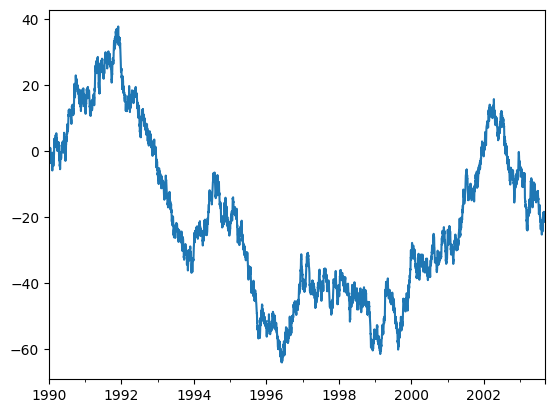

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 640x480 with 0 Axes>

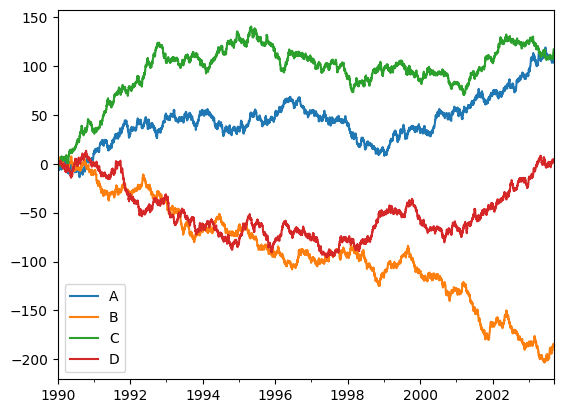

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.459516,0.714263,-1.639617,1.062154
1,1990-01-02,-0.334644,0.150054,0.222422,0.702139
2,1990-01-03,-1.957258,1.284773,1.117559,0.495352
3,1990-01-04,-2.295117,2.880433,0.632027,1.196071
4,1990-01-05,-2.850256,2.247231,1.281026,-1.279036
...,...,...,...,...,...
4995,2003-09-05,105.017118,-184.234105,113.732397,4.387394
4996,2003-09-06,104.094961,-185.864985,114.558868,3.516114
4997,2003-09-07,103.781655,-186.007186,115.493434,3.785521
4998,2003-09-08,103.278503,-187.045302,115.900931,4.121743


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,0.459516,0.714263,-1.639617,1.062154
1990-01-02,-0.334644,0.150054,0.222422,0.702139
1990-01-03,-1.957258,1.284773,1.117559,0.495352
1990-01-04,-2.295117,2.880433,0.632027,1.196071
1990-01-05,-2.850256,2.247231,1.281026,-1.279036
...,...,...,...,...
2003-09-05,105.017118,-184.234105,113.732397,4.387394
2003-09-06,104.094961,-185.864985,114.558868,3.516114
2003-09-07,103.781655,-186.007186,115.493434,3.785521
2003-09-08,103.278503,-187.045302,115.900931,4.121743


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.459516,0.714263,-1.639617,1.062154
1,1990-01-02,-0.334644,0.150054,0.222422,0.702139
2,1990-01-03,-1.957258,1.284773,1.117559,0.495352
3,1990-01-04,-2.295117,2.880433,0.632027,1.196071
4,1990-01-05,-2.850256,2.247231,1.281026,-1.279036
...,...,...,...,...,...
4995,2003-09-05,105.017118,-184.234105,113.732397,4.387394
4996,2003-09-06,104.094961,-185.864985,114.558868,3.516114
4997,2003-09-07,103.781655,-186.007186,115.493434,3.785521
4998,2003-09-08,103.278503,-187.045302,115.900931,4.121743


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a   -0.069073
b    0.583125
c   -0.606153
d   -0.631152
e   -0.545271
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0    0.918587
1   -0.848892
2    1.676871
3   -0.927249
4    0.024635
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

a   -0.069073
b    0.583125
dtype: float64

In [114]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [117]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [118]:
bb[bb.columns[:9]].dtypes

Unnamed: 0                         object
Unnamed: 1                         object
Unnamed: 2                         object
Unnamed: 3                         object
Unnamed: 4                         object
Unnamed: 5                         object
Unnamed: 6                         object
Percent change\nJan 2023 from -    object
Unnamed: 8                         object
dtype: object

In [122]:
# pip install pytorch-forecasting
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

# load data
data = ...

# define dataset
max_encoder_length = 36
max_prediction_length = 6
training_cutoff = "YYYY-MM-DD"  # day for cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.date < training_cutoff],
    time_idx= ...,
    target= ...,
    # weight="weight",
    group_ids=[ ... ],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[ ... ],
    static_reals=[ ... ],
    time_varying_known_categoricals=[ ... ],
    time_varying_known_reals=[ ... ],
    time_varying_unknown_categoricals=[ ... ],
    time_varying_unknown_reals=[ ... ],
)

# create validation and training dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
)

# create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

TypeError: ignored

##PyTorch Forecasting
**Building a simple first model**

Starting witha simple fully connected model, it'll take a timeseries of size `input_size` as input and outputs a new timeseries of size `output_size`. 

In [123]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [124]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
    super().__init__()

    # input layer
    module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    # hidden layers
    for _ in range(n_hidden_layers):
        module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
    # output layer
    module_list.append(nn.Linear(hidden_size, output_size))

    self.sequential = nn.Sequential(*module_list)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x of shape: batch_size x n_timesteps_in
      # output of shape batch_size x n_timesteps_out
      return self.sequential(x)

# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])

The above model is not yet a PyTorch Forecasting model but it is easy to get there. As this is a simple model, we will use the `BaseModel`. This base class is modified `LightningModule` with pre-defined hooks for training and validating time series models. The main requirement is for the model to have a forward method.

In [125]:
def forward(self, x:
    # x is a batch generated based on the TimeSeriesDataset, here we just use the
    # continuous variables for the encoder
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.linear(network_input)  #

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

SyntaxError: ignored

In [126]:
from typing import Dict

from pytorch_forecasting.models import BaseModel

class FullyConnectedModule(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

##Passing data to a model

Instead of having to write our own dataloader, we can leverage PyTorch Forecasting’s `TimeSeriesDataSet` to feed data to our model. In fact, PyTorch Forecasting expects us to use a `TimeSeriesDataSet`.

The data has to be in a specific format to be used by the `TimeSeriesDataSet`. It should be in a pandas DataFrame and have a categorical column to identify each series and a integer column to specify the time of the record.

Below, we create such a dataset with 30 different observations - 10 for 3 time series.

In [127]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) -0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
test_data 

,value,group,time_idx
0,-0.207405,0,0
1,0.251795,0,1
2,-0.272225,0,2
3,0.081466,0,3
4,0.183603,0,4
5,-0.194973,0,5
6,0.082289,0,6
7,0.013363,0,7
8,-0.159618,0,8
9,0.027947,0,9


We can convert it to a `TimeSeriesDataSet` easily.

In [128]:
from pytorch_forecasting import TimeSeriesDataSet

# create the dataset from the pandas dataframe
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
)

We can take a look at all the defaults and settings preset by PyTorch Forecasting. These are all available as arguments in `TimeSeriesDataSet`.

In [129]:
dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 5,
 'min_encoder_length': 5,
 'min_prediction_idx': 0,
 'min_prediction_length': 2,
 'max_prediction_length': 2,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': GroupNormalizer(
 	method='standard',
 	groups=[],
 	center=True,
 	scale_by_group=False,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True),
  'group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

Now when we take a look at the output of the dataloader. It's `x` will be fed to the model's forward method.

In [130]:
# convert the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(4, 5, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-1.2887],
         [ 0.1850],
         [ 0.6106],
         [-0.9668],
         [ 0.1884]],

        [[-2.0832],
         [ 1.4671],
         [-0.1693],
         [ 1.2902],
         [ 0.3295]],

        [[-1.0186],
         [ 0.8947],
         [-1.2887],
         [ 0.1850],
         [ 0.6106]],

        [[ 0.8947],
         [-1.2887],
         [ 0.1850],
         [ 0.6106],
         [-0.9668]]]), 'encoder_target': tensor([[-0.2722,  0.0815,  0.1836, -0.1950,  0.0823],
        [-0.4629,  0.3892, -0.0036,  0.3467,  0.1161],
        [-0.2074,  0.2518, -0.2722,  0.0815,  0.1836],
        [ 0.2518, -0.2722,  0.0815,  0.1836, -0.1950]]), 'encoder_lengths': tensor([5, 5, 5, 5]), 'decoder_cat': tensor([], size=(4, 2, 0), dtype=torch.int64), 'decoder_cont': tensor([[[-0.0988],
         [-0.8195]],

        [[ 0.8295],
         [-1.0336]],

        [[-0.9668],
         [ 0.1884]],

        [[ 0.1884],
   

Weight by samples for training:

In [131]:
from torch.utils.data import WeightedRandomSampler

# length of probabilties for sampler have to be equal to the length of the index
probabilities = np.sqrt(1 + data.loc[dataset.index, "target"])
sampler = WeightedRandomSampler(probabilities, len(probabilities))
dataset.to_dataloader(train=True, sampler=sampler, shuffle=False)

AttributeError: ignored

In [132]:
def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    # x is a batch generated based on the TimeSeriesDataset
    network_input = x["encoder_cont"].squeeze(-1)
    prediction = self.network(network_input)

    # rescale predictions into target space
    prediction = self.transform_output(prediction, target_scale=x["target_scale"])

    # We need to return a dictionary that at least contains the prediction
    # The parameter can be directly forwarded from the input.
    # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
    return self.to_network_output(prediction=prediction)

In [133]:
model = FullyConnectedModel.from_dataset(dataset, input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x, y = next(iter(dataloader))
model(x)

NameError: ignored

In [134]:
dataset.x_to_index(x)

,time_idx,group
0,7,0
1,7,1
2,5,0
3,6,0


**Coupling datasets and models**

In [135]:
class FullyConnectedModel(BaseModel):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x:Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input).unsqueeze(-1)

        #rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        #We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversation to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs ={
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)

Let's initialize from our dataset:

In [136]:
from lightning.pytorch.utilities.model_summary import ModelSummary

model = FullyConnectedModel.from_dataset(dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

RecursionError: ignored

##Defining additional hyperparameters

So far, we have 

In [137]:
model.hparams

NameError: ignored

In [138]:
print(BaseModel.__init__.__doc__)


        BaseModel for timeseries forecasting from which to inherit from

        Args:
            log_interval (Union[int, float], optional): Batches after which predictions are logged. If < 1.0, will log
                multiple entries per batch. Defaults to -1.
            log_val_interval (Union[int, float], optional): batches after which predictions for validation are
                logged. Defaults to None/log_interval.
            learning_rate (float, optional): Learning rate. Defaults to 1e-3.
            log_gradient_flow (bool): If to log gradient flow, this takes time and should be only done to diagnose
                training failures. Defaults to False.
            loss (Metric, optional): metric to optimize, can also be list of metrics. Defaults to SMAPE().
            logging_metrics (nn.ModuleList[MultiHorizonMetric]): list of metrics that are logged during training.
                Defaults to [].
            reduce_on_plateau_patience (int): patience after which 

##Classification

In [139]:
classification_test_data = pd.DataFrame(
    dict(
        target=np.random.choice(["A", "B", "C"], size=30), #CHANGING values to predict to a categorical
        value=np.random.rand(30), # INPUT values
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
classification_test_data

,target,value,group,time_idx
0,A,0.566704,0,0
1,B,0.860483,0,1
2,A,0.375340,0,2
3,A,0.505898,0,3
4,B,0.600333,0,4
5,C,0.962263,0,5
6,A,0.937406,0,6
7,C,0.855621,0,7
8,C,0.603974,0,8
9,A,0.235424,0,9


In [140]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# create the dataset from the pandas dataframe
classification_dataset = TimeSeriesDataSet(
    classification_test_data,
    group_ids=["group"],
    target="target",  # SWITCHING to categorical target
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"],
    target_normalizer=NaNLabelEncoder(),  # Use the NaNLabelEncoder to encode categorical target
)

x, y = next(iter(classification_dataset.to_dataloader(batch_size=4)))
y[0]  # target values are encoded categories

tensor([[2, 2],
        [2, 0],
        [0, 0],
        [0, 2]])

In [141]:
from pytorch_forecasting.metrics import CrossEntropy


class FullyConnectedClassificationModel(BaseModel):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        n_classes: int,
        loss=CrossEntropy(),
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size * self.hparams.n_classes,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_cont"].size(0)
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)
        # RESHAPE output to batch_size x n_decoder_timesteps x n_classes
        prediction = prediction.unsqueeze(-1).view(batch_size, -1, self.hparams.n_classes)

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a named tuple that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        assert isinstance(dataset.target_normalizer, NaNLabelEncoder), "target normalizer has to encode categories"
        new_kwargs = {
            "n_classes": len(
                dataset.target_normalizer.classes_
            ),  # ADD number of classes as encoded by the target normalizer
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
        ), "Only covariate should be in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)


model = FullyConnectedClassificationModel.from_dataset(classification_dataset, hidden_size=10, n_hidden_layers=2)
print(ModelSummary(model, max_depth=-1))
model.hparams

RecursionError: ignored

In [142]:
# passing x through model
model(x)["prediction"].shape

NameError: ignored

##Predicting multiple targets at the same time

In [143]:
multi_target_test_data = pd.DataFrame(
    dict(
        target1=np.random.rand(30),
        target2=np.random.rand(30),
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3),
    )
)
multi_target_test_data

,target1,target2,group,time_idx
0,0.481633,0.369053,0,0
1,0.107975,0.380152,0,1
2,0.152720,0.619805,0,2
3,0.568761,0.883792,0,3
4,0.484618,0.512872,0,4
5,0.631709,0.533232,0,5
6,0.989213,0.283578,0,6
7,0.903908,0.183800,0,7
8,0.017816,0.398078,0,8
9,0.187779,0.625878,0,9


In [144]:
from pytorch_forecasting.data.encoders import EncoderNormalizer, MultiNormalizer, TorchNormalizer

# create the dataset from the pandas dataframe
multi_target_dataset = TimeSeriesDataSet(
    multi_target_test_data,
    group_ids=["group"],
    target=["target1", "target2"],  # USING two targets
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["target1", "target2"],
    target_normalizer=MultiNormalizer(
        [EncoderNormalizer(), TorchNormalizer()]
    ),  # Use the NaNLabelEncoder to encode categorical target
)

x, y = next(iter(multi_target_dataset.to_dataloader(batch_size=4)))
y[0]  # target values are a list of targets

[tensor([[0.9039, 0.0178],
         [0.6317, 0.9892],
         [0.0178, 0.1878],
         [0.8687, 0.2527]]),
 tensor([[0.1838, 0.3981],
         [0.5332, 0.2836],
         [0.3981, 0.6259],
         [0.4392, 0.8960]])]